# Einleitung zur Übung: "Sensor Sensitivity"

In dieser Übung beschäftigen wir uns mit dem Einfluss von Umweltparametern – insbesondere Temperatur, Luftfeuchtigkeit und Druck – auf die CO₂-Messungen. Moderne Messinstrumente wie der GMP343 nutzen interne Kompensationsalgorithmen, um Einflüsse sowohl aus den physikalischen Messbedingungen als auch aus instrumentspezifischen Eigenschaften zu eliminieren. Dabei wird die Temperaturkompensation automatisch über einen integrierten Temperatursensor durchgeführt, während andere Umgebungsparameter, wie Luftfeuchtigkeit, Sauerstoffkonzentration und Druck, von zusätzlichen Sensoren im Luftstrom gemessen und dann den GMP343 gesendet werden müssen.

In [107]:
import polars as pl
import os
import sys
import numpy as np

# Add the parent directory to the system path
PROJECT_PATH = os.path.abspath(os.path.join(".."))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from utils.plot_dataframes import plot_columns
from utils.plot_sensitivities import plot_scatter_with_trendline

In [108]:
df_s = pl.read_parquet("../data/4_Sensor_Sensitivity/2025_Sensor_GMP343_Measurement.parquet")
df_s_3 = df_s.filter(pl.col("system_id") == 3)
df_s_6 = df_s.filter(pl.col("system_id") == 6)

df_sbs_2024 = pl.read_parquet("../data/4_Sensor_Sensitivity/2024_Sensor_GMP343_Measurement.parquet")

# Analyse von zwei Systemen zur gleichen Zeit am gleichen Ort

shape: (2, 4)
┌───────────┬───────────┬──────────┬──────────┐
│ system_id ┆ MEAN      ┆ MAE      ┆ RMSE     │
│ ---       ┆ ---       ┆ ---      ┆ ---      │
│ i32       ┆ f64       ┆ f64      ┆ f64      │
╞═══════════╪═══════════╪══════════╪══════════╡
│ 3         ┆ 0.376829  ┆ 0.498575 ┆ 0.604028 │
│ 6         ┆ -0.591404 ┆ 0.735412 ┆ 0.898637 │
└───────────┴───────────┴──────────┴──────────┘


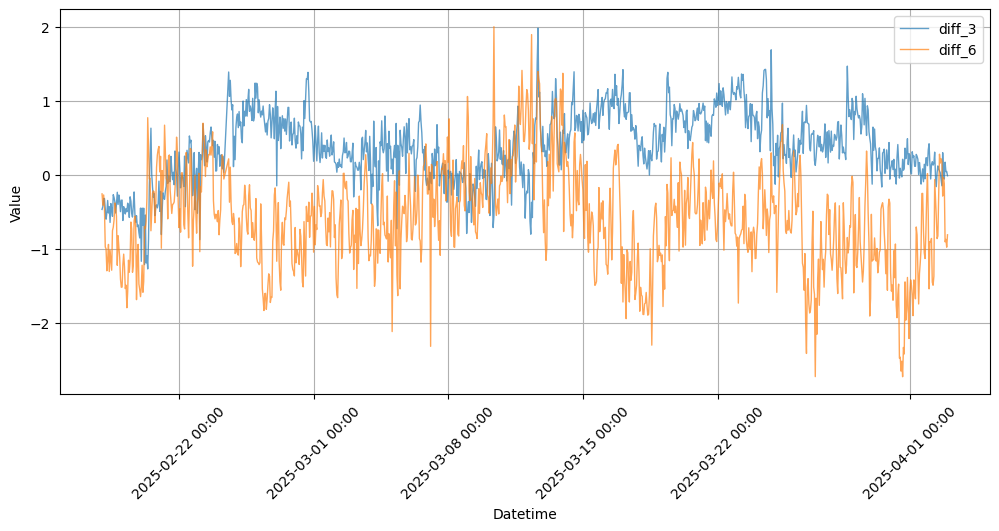

In [109]:
df_plot = df_s_3.select("datetime", "diff").join(df_s_6.select("datetime", "diff"), on="datetime", how="inner", suffix="_6").rename({"diff": "diff_3"})

print(df_s.group_by(["system_id"]) \
    .agg([
            (pl.col("diff").mean()).alias("MEAN"),
            (np.abs(pl.col("diff"))).mean().alias("MAE"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("RMSE")
        ]) \
    .sort("system_id"))

plot_columns(df_plot, "datetime", ["diff_3", "diff_6"])

# Praktische Übung 1

- Plotte ein Histogram

Fragen

- Welches der beiden Systeme weist hinsichtlich der Messgenauigkeit und -stabilität eine geringere Schwankungsbreite auf?
- Wie groß ist die maximale Variabilität, d.h. die Differenz zwischen dem höchsten und dem niedrigsten Messwert, für jedes der Systeme?
- Was könnten mögliche Gründe dafür sein?

---

# Analyse der Variabilität von atmosphärischen Parametern

In dieser Übung betrachten wir detailliert die Messreihen zweier Sensorsysteme, indem wir die Zeitreihen für verschiedene Umweltparameter analysieren. Konkret untersuchen wir die folgenden Variablen:

- **Temperatur**
- **Relative Luftfeuchtigkeit (rH)**
- **Wasserdampfanteil (H₂O in Vol%)**
- **Druck (p)**

Diese Messreihen geben uns einen umfassenden Einblick in die Umgebungsbedingungen, unter denen die beiden Systeme betrieben werden. Ziel ist es, die zeitliche Dynamik und mögliche Unterschiede zwischen den Systemen zu erkennen. Dabei sollen unter anderem folgende Aspekte beleuchtet werden:

- Wie variieren die Umweltparameter über den Messzeitraum?
- Wie schnell ändern sich unterschiedliche Umweltparameter?
- Gibt es systematische Unterschiede zwischen den beiden Systemen hinsichtlich der gemessenen Temperaturen, Feuchtigkeitswerte, Drücke und H₂O-Anteile?

Diese Analyse legt die Grundlage, um später auch Zusammenhänge zwischen den Umweltparametern und der Leistung bzw. den Kalibrierungsparametern der Sensorsysteme zu untersuchen. Indem wir diese Zeitreihen vergleichend betrachten, können wir besser verstehen, wie die Betriebsbedingungen die Messdaten beeinflussen.

## System 6 (v1) & System 3 (v2)

Details zum Systemdesign für v1 und v2 erfahrt ihr zu einem späteren Zeitpunkt in dieser Übung.

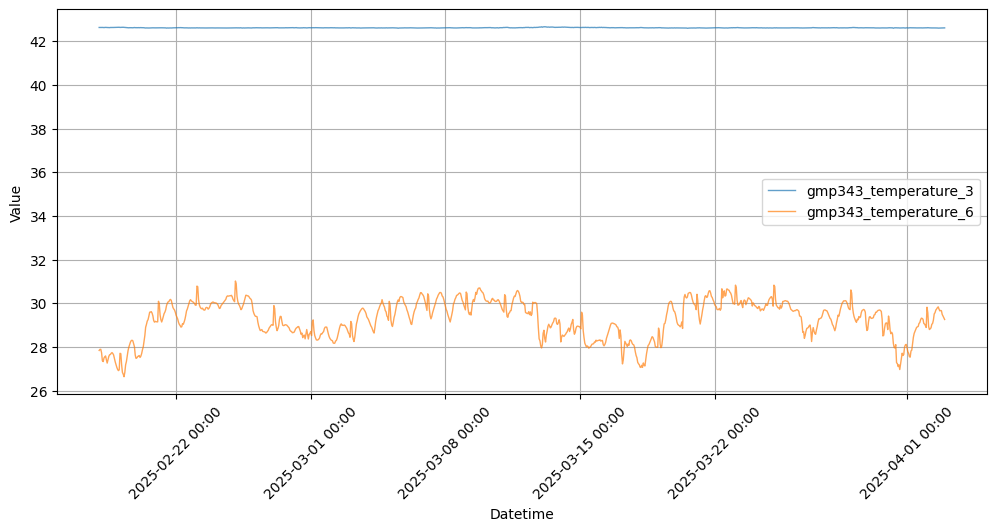

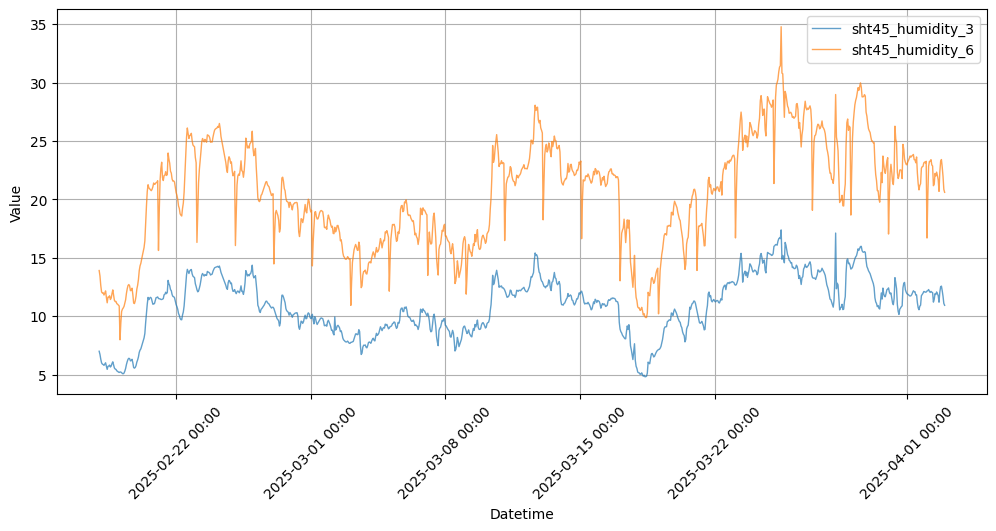

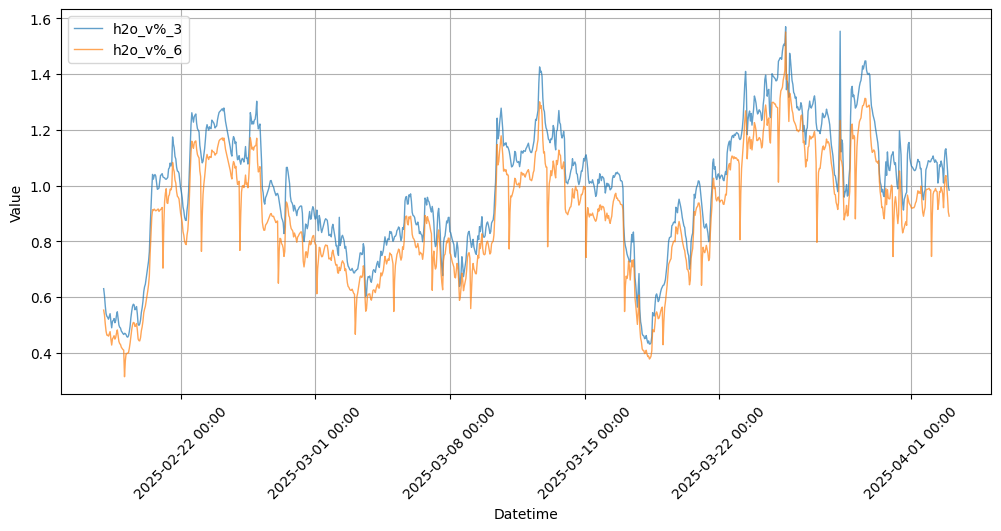

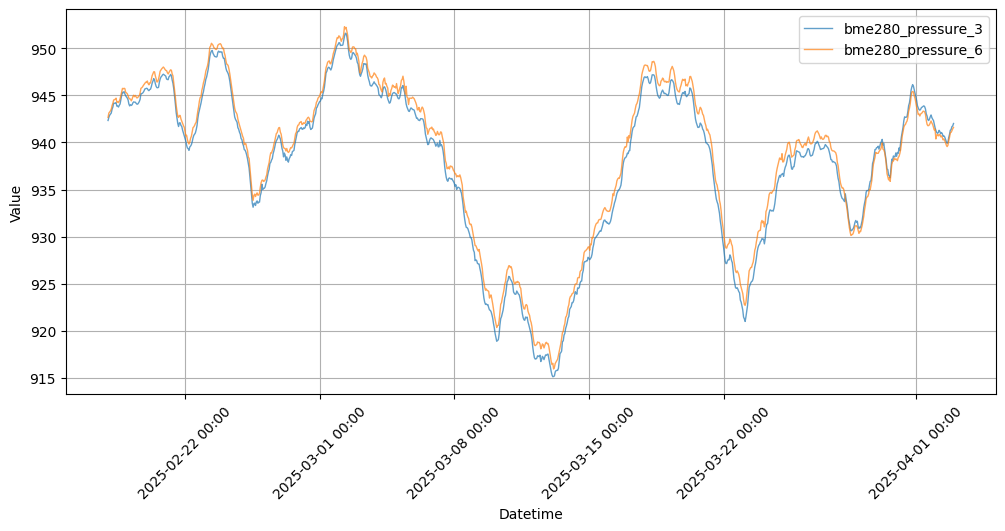

In [110]:
rename_dict = {col: col + "_3" for col in df_s_3.columns}

df_plot = df_s_3.join(df_s_6, on="datetime", how="inner", suffix="_6").rename(rename_dict).rename({"datetime_3": "datetime"})

plot_columns(df_plot, "datetime", ["gmp343_temperature_3", "gmp343_temperature_6"])
plot_columns(df_plot, "datetime", ["sht45_humidity_3", "sht45_humidity_6"])
plot_columns(df_plot, "datetime", ["h2o_v%_3", "h2o_v%_6"])
plot_columns(df_plot, "datetime", ["bme280_pressure_3", "bme280_pressure_6"])


# Praktikische Übung 2

- Ermittle die maximalen Variabilität (max - min) für die Parameter (Temperatur (°C), relative Luftfeuchtigkeit (%), absolute Luftfeuchtigkeit (v%), Druck (hPa))
- Berechne die Varianz und Standardabweichung für die Parameter (Temperatur (°C), relative Luftfeuchtigkeit (%), absolute Luftfeuchtigkeit (v%), Druck (hPa))

## Nützliche Funktionen

- [Polars Column Selection](https://docs.pola.rs/api/python/dev/reference/dataframe/api/polars.DataFrame.select.html#polars.DataFrame.select)
- [Polars DataFrame Aggregations](https://docs.pola.rs/api/python/dev/reference/dataframe/aggregation.html)
- [Polars Item Selector](https://docs.pola.rs/api/python/dev/reference/dataframe/api/polars.DataFrame.item.html#polars.DataFrame.item)

In [111]:
df_s_3.head(1)

system_id,datetime,CO2_processed,CO2_reference,gmp343_temperature,sht45_humidity,h2o_v%,bme280_pressure,diff
i32,datetime[ms],f64,f64,f64,f64,f64,f64,f64
3,2025-02-18 00:00:00,481.673333,482.145167,42.628333,6.993528,0.62969,942.340694,-0.471833


In [112]:
df_s_6.head(1)

system_id,datetime,CO2_processed,CO2_reference,gmp343_temperature,sht45_humidity,h2o_v%,bme280_pressure,diff
i32,datetime[ms],f64,f64,f64,f64,f64,f64,f64
6,2025-02-18 00:00:00,481.883333,482.145167,27.835833,13.905889,0.552706,942.668194,-0.261833


In [113]:
# DataFrames für die zwei Systeme: (3: df_s_3, 6: df_s_6)
# Columns (Spalten): ["gmp343_temperature", "sht45_humidity", "h2o_v%", "bme280_pressure"] 


Fragen:

- Welche Unterschiede kannst du zwischen den beiden System herauslesen?
- Was könnten Gründe für die Temperaturstabilisierung von System v2 sein?

---

# Hintergrund zur Kompensation von Umwelteinflüssen

Die Genauigkeit von Sensorsystemen wird maßgeblich von Umwelteinflüssen beeinflusst. Eine zuverlässige Messung erfordert daher eine gezielte Kompensation dieser Einflüsse. Im Folgenden werden wesentliche Aspekte der Sensitivitätskompensation erläutert:

- **Individuelle Sensorcharakteristik:**  
  Jeder Sensor reagiert individuell auf Veränderungen der Umwelt. Fertigungsunterschiede, Materialvariationen und auch die mechanische Verarbeitung führen dazu, dass selbst Sensoren desselben Typs unterschiedliche Sensitivitätsprofile aufweisen. Das bedeutet, dass die Reaktion eines Sensors auf Temperatur, Druck, Luftfeuchtigkeit oder andere Umweltparameter variiert. Um präzise Messungen zu gewährleisten, muss für jeden Sensor separat festgestellt werden, wie stark er auf diese Einflüsse reagiert. Nur so können exakte Korrekturfaktoren ermittelt werden, die die Rohdaten in valide Messwerte umrechnen.

- **Kompensation der Sensitivität auf Basis von Labortests:**  
  Eine Möglichkeit, die individuellen Sensitivitätsprofile zu erfassen, sind umfassende Labortests. In einem kontrollierten Umfeld werden die Sensoren gezielt verschiedenen, genau definierten Umweltbedingungen ausgesetzt. Beispielsweise kann ein Sensor in einem Klimakammer-Test unterschiedlichen Temperaturen, Drücken und Feuchtigkeitswerten ausgesetzt werden. Die daraus gewonnenen Daten ermöglichen es, für jeden Sensor eine detaillierte Kalibrierungskurve zu erstellen. Diese Kalibrierungsparameter werden dann im Postprocessing genutzt, um die Messwerte an die tatsächlichen Bedingungen anzupassen.

- **Herausforderungen und Aufwand von Labortests:**  
  Solche Labortests sind sehr aufwendig und kostenintensiv, da sie präzise Steuerung der Testbedingungen, wiederholte Messungen und umfangreiche Datenanalysen erfordern. Ein Beispiel hierfür ist der Testaufbau in einem Temperatur- und Feuchtigkeitslabor, in dem Sensoren über einen längeren Zeitraum unter variierenden, aber kontrollierten Bedingungen betrieben werden. Die statistische Auswertung dieser Messreihen ermöglicht es, auch kleine Unterschiede in der Sensitivität zu identifizieren und zu korrigieren. Aufgrund des hohen Aufwands ist eine sorgfältige Planung und Dokumentation dieser Tests unerlässlich.

- **Werkseitige Kompensation:**  
  Um den Aufwand zu minimieren, verfügen manche Sensoren, wie beispielsweise der Vaisala GMP343, bereits ab Werk über interne Kompensationsmechanismen. Diese Sensoren sind so konzipiert, dass sie kritische Umweltparameter wie Temperatur intern messen und automatisch korrigieren. Dadurch wird der Korrekturbedarf im Nachhinein reduziert, und es müssen weniger aufwendige Labortests durchgeführt werden.

---

# Scatter Plots: Interne Kompensation von Druck und Wasserdampf Einflüssen

- Selbst mit aktivierter interner Sensor Kompensation und stabilisierten System, können noch Einflüsse auf die Messgenauigkeit beobachtet werden. In dieser Übung versuchen wir Werkzeuge zu finden, dies sichtbar zu machen.

- Scatter Plots verstehen
- Scatter Plots für Druck und Wasser

# Scatter Plots: Interne Kompensation von Druck- und Wasserdampfeinflüssen

Auch wenn Sensoren über eine aktive interne Kompensation verfügen und das System stabilisiert ist, können dennoch Einflüsse von Druck- und Wasserdampfänderungen auf die Messgenauigkeit sichtbar sein. In dieser Übung geht es darum, geeignete Werkzeuge zu identifizieren und anzuwenden, um diese Einflüsse zu visualisieren und besser zu verstehen.

## Motivation

Die Messgenauigkeit eines Sensors ist entscheidend für die Zuverlässigkeit der gesammelten Daten. Selbst bei modernster Technik können Umwelteinflüsse – wie Schwankungen im Umgebungsdruck oder in der Wasserdampfkonzentration – den Messwert verfälschen. Scatter Plots bieten eine intuitive Möglichkeit, diese Einflüsse sichtbar zu machen und zu analysieren. 

Diese Übung soll euch helfen:
- Den Einsatz von Scatter Plots als Analysewerkzeug zu verstehen.
- Die spezifischen Auswirkungen von Druck- und Wasserdampfeinflüssen auf das Sensorsignal zu erkennen.
- Verstehen wie die Sensitvität sich von Sensor zu Sensore unterscheidet
- Ansätze zu diskutieren, wie durch weitere Korrekturmaßnahmen oder Systemoptimierungen die Messgenauigkeit verbessert werden kann.

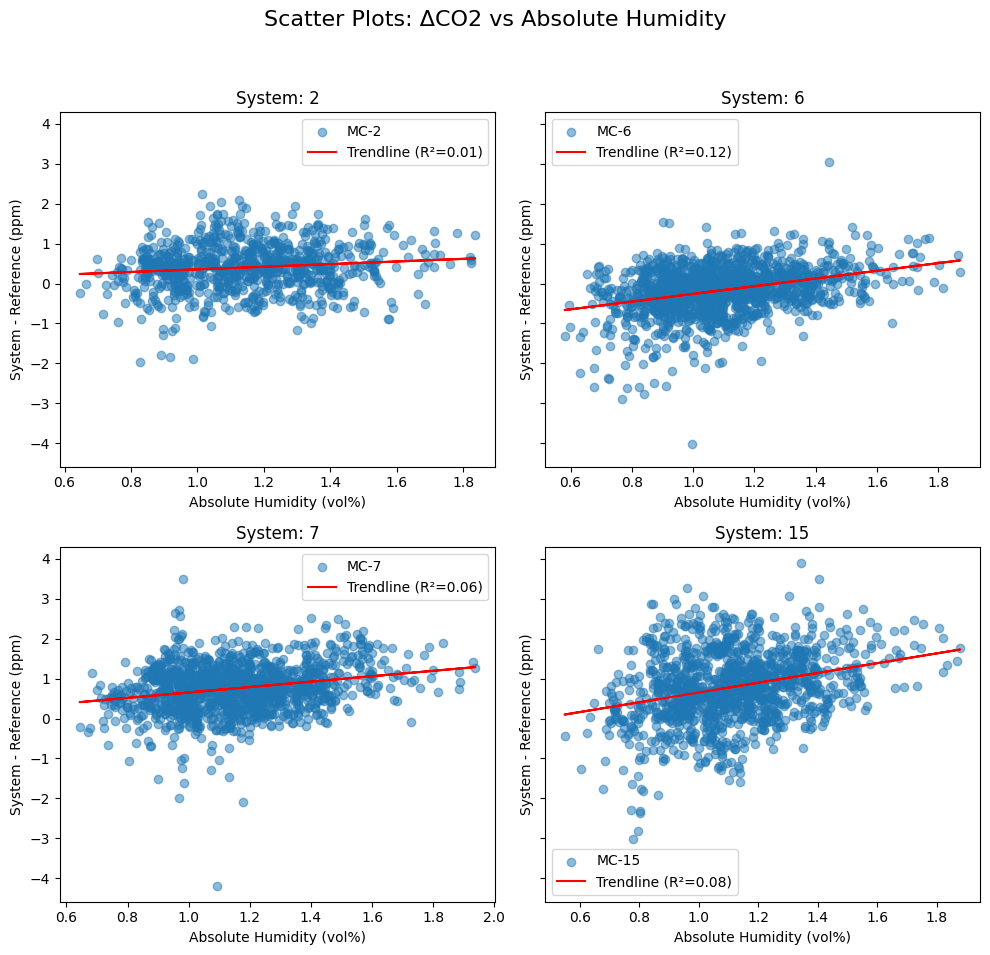

In [114]:
max_col, max_row = 2, 2

plot_scatter_with_trendline(df_sbs_2024, "h2o_v%", "diff", max_col, max_row, "Absolute Humidity (vol%)", "System - Reference (ppm)","Scatter Plots: ΔCO2 vs Absolute Humidity")

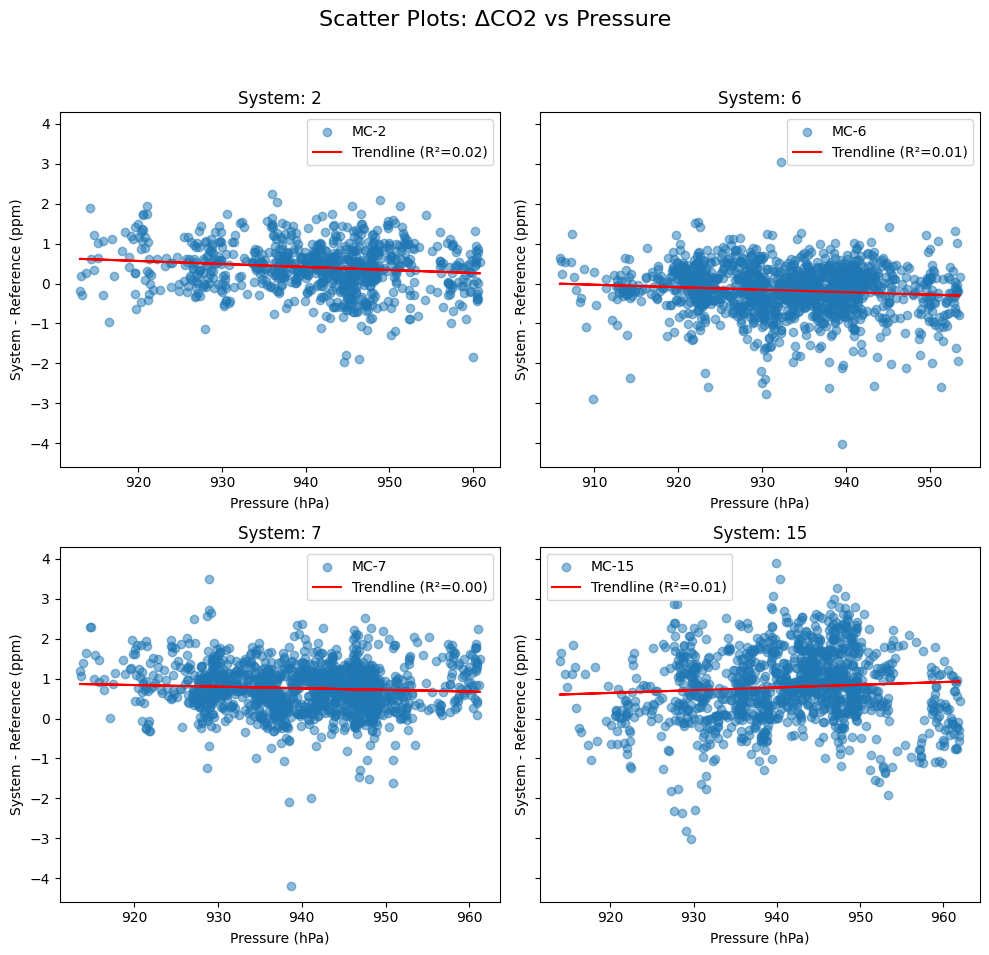

In [115]:
max_col, max_row = 2, 2

plot_scatter_with_trendline(df_sbs_2024, "bme280_pressure", "diff", max_col, max_row, "Pressure (hPa)", "System - Reference (ppm)","Scatter Plots: ΔCO2 vs Pressure" )

## Praktische Übung 3 
Berechne die Stärke des Fehlers auf das CO2 Signal
  
.

.

.

.

.

.

.

---

# Scatter Plots: Interne Kompensation von Temperatureinflüssen

In dieser Übung untersuchen wir, wie gut unsere Sensorsysteme Temperatureinflüsse kompensieren – ein Parameter, der oft weniger stabil korrigiert wird als Druck oder Wasserdampf. Obwohl die interne Kompensation bei manchen Umweltgrößen zuverlässig arbeitet, zeigt sich bei der Temperatur, dass es zu Schwankungen kommen kann. Diese Schwankungen können sich beispielsweise zeigen, wenn der Sensor innerhalb einer stabilisierten Temperaturzone (26–32 °C) arbeitet oder wenn er außerhalb dieses Bereichs, etwa über 32 °C, durch Sonneneinstrahlung der Außenbox zusätzlich aufgeheizt wird.

## Ziel der Übung

- **Minimierung externer Störeinflüsse:**  
  Durch den Einsatz von Temperaturstabilisierungssystemen können die Sensoren in einem möglichst konstanten Umfeld betrieben werden, was die Variabilität der Sensitivität reduziert und zu repräsentativeren Kalibrierungen führt.

- **Fokus auf Temperatureinflüsse:**  
  Wir konzentrieren uns darauf, den Einfluss von Temperatur auf die Sensorleistung sichtbar zu machen. Mithilfe von Scatter Plots analysieren wir, wie sich die Messwerte in Abhängigkeit von der Temperatur verhalten.

## Untersuchungsfrage

- **Wie verhalten sich die Sensorsignale innerhalb der stabilisierten Temperaturzone von 26–32 °C im Vergleich zu den Messungen außerhalb dieses Bereichs (z. B. >32 °C, wenn die Außenbox durch Sonneneinstrahlung im Sommer aufgeheizt wird)?**

Diese Analyse hilft uns zu verstehen, inwieweit die interne Temperaturkompensation effektiv arbeitet und welche Herausforderungen weiterhin bestehen, wenn die Temperatur den vorgesehenen Stabilitätsbereich verlässt.

## Scatter Plot für Temperatur geregelt (< 32 Grad)

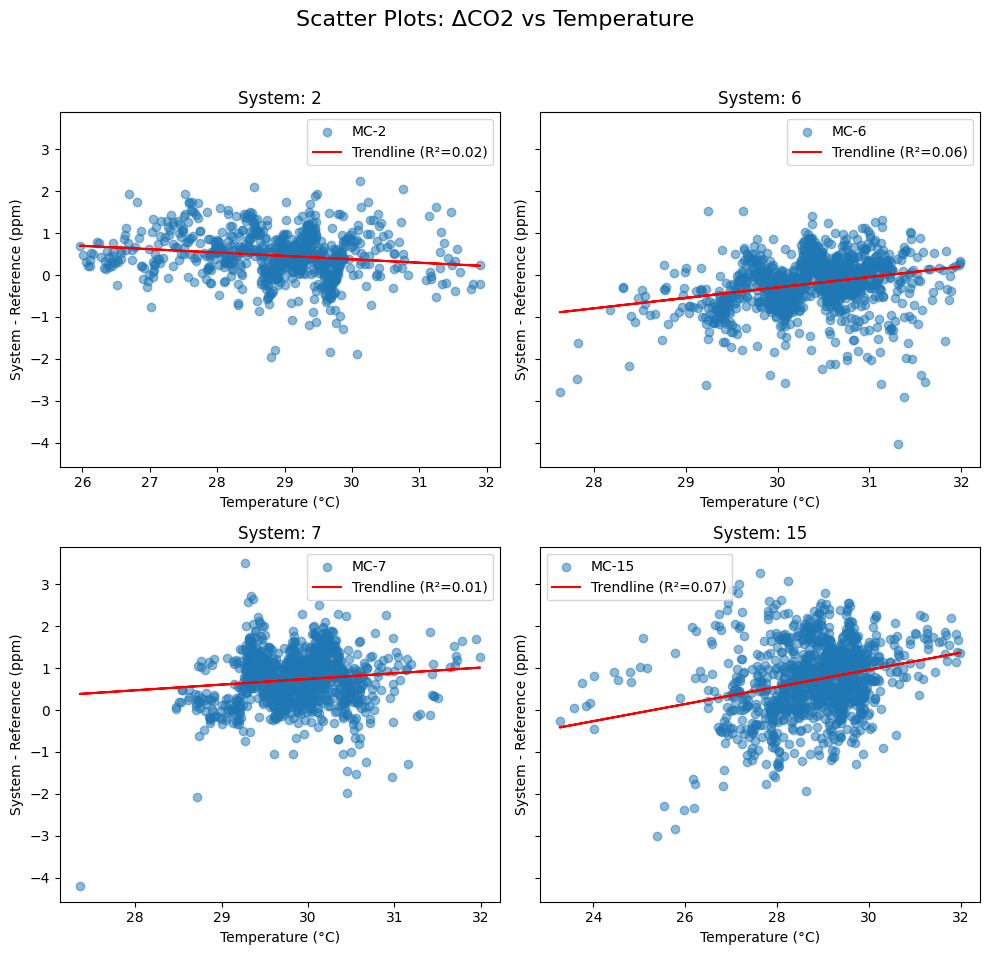

In [116]:
max_col, max_row = 2, 2

df_plot = df_sbs_2024.filter(pl.col("gmp343_temperature") < 32)

plot_scatter_with_trendline(df_plot, "gmp343_temperature", "diff", max_col, max_row, "Temperature (°C)", "System - Reference (ppm)","Scatter Plots: ΔCO2 vs Temperature")

## Scatter Plot für Temperatur außerhalb der Regelung (Sonneneinstrahlung > 32°C)

### Technischer Hintergrund

- **Systeme (v1):**  
  In der Outdoor-Enclosure wird die Temperatur mittels einer Hysterese-Regelung (über Heizer und Lüfter) auf ±3°C stabilisiert. Das bedeutet, dass die Temperatur innerhalb eines Toleranzbereichs von 3°C um den Sollwert gehalten wird. Bei starker Sonneneinstrahlung oder starkem kaltem Wind stößt dieses System jedoch an seine Grenzen, wodurch die Temperaturkontrolle weniger präzise wird.


### Ziel der Analyse

In dieser Übung untersuchen wir Scatter Plots, um den Zusammenhang zwischen der Änderung der CO₂-Konzentration (ΔCO₂) und der Temperatur für Temperaturwerte über 32°C zu untersuchen, in denen der Einfluss der Sonneneinstrahlung deutlich wird und sich die Grenzen der Temperaturregelung in den Systemen bemerkbar machen.

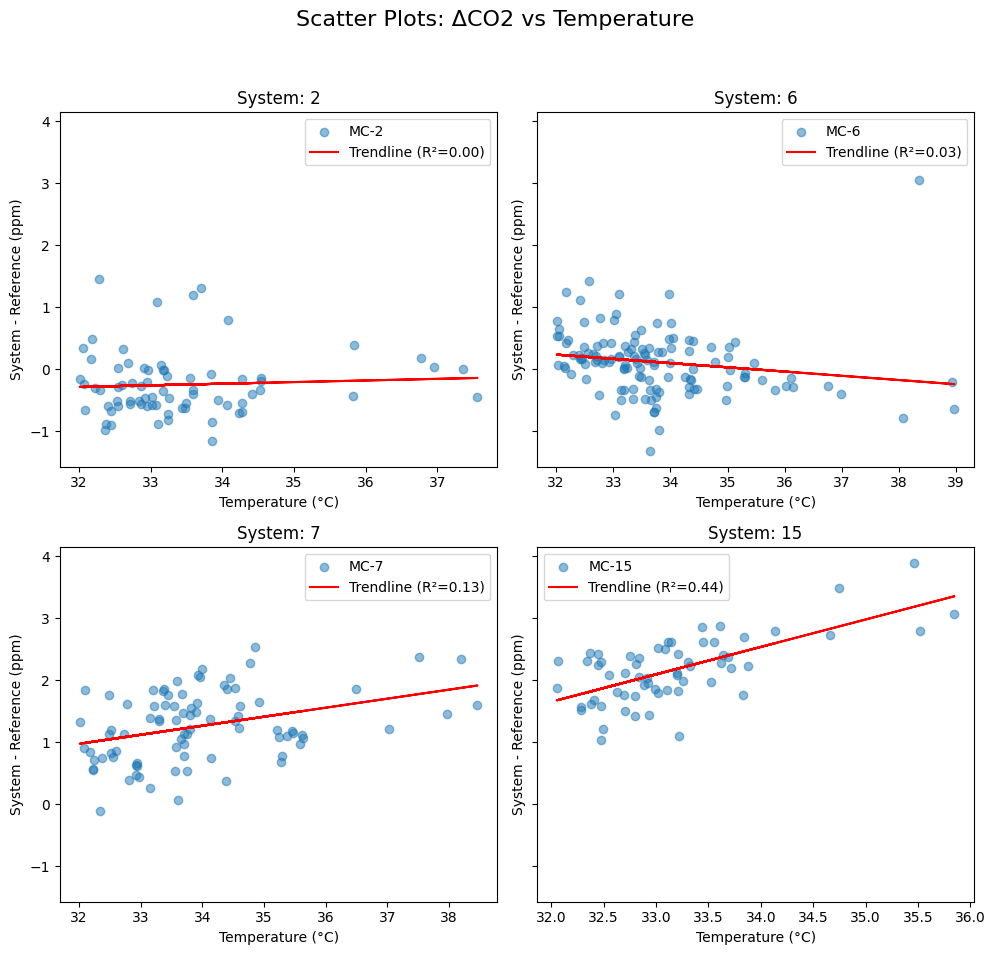

In [117]:
max_col, max_row = 2, 2

df_plot = df_sbs_2024.filter(pl.col("gmp343_temperature") > 32)

plot_scatter_with_trendline(df_plot, "gmp343_temperature", "diff", max_col, max_row, "Temperature (°C)", "System - Reference (ppm)","Scatter Plots: ΔCO2 vs Temperature")

## Praktische Übung 4 
Berechne die Stärke des Fehlers auf das CO2 Signal

.

.

.

.

.

.

.

---

## Scatter Plot für Temperaturregelung zwischen v1 und v2

### Technischer Hintergrund

- **System 3 (v2):**  
  Dieses System ist zusätzlich zur Temperaturregelung in der Aussenbox mit einer PID-geregelten Heat Box ausgestattet, die direkt um den Sensor angeordnet ist. Durch diese präzise Regelung wird die Temperatur auf ±0,1°C stabil gehalten, was zu einer wesentlich stabileren und konsistenteren Messumgebung führt.

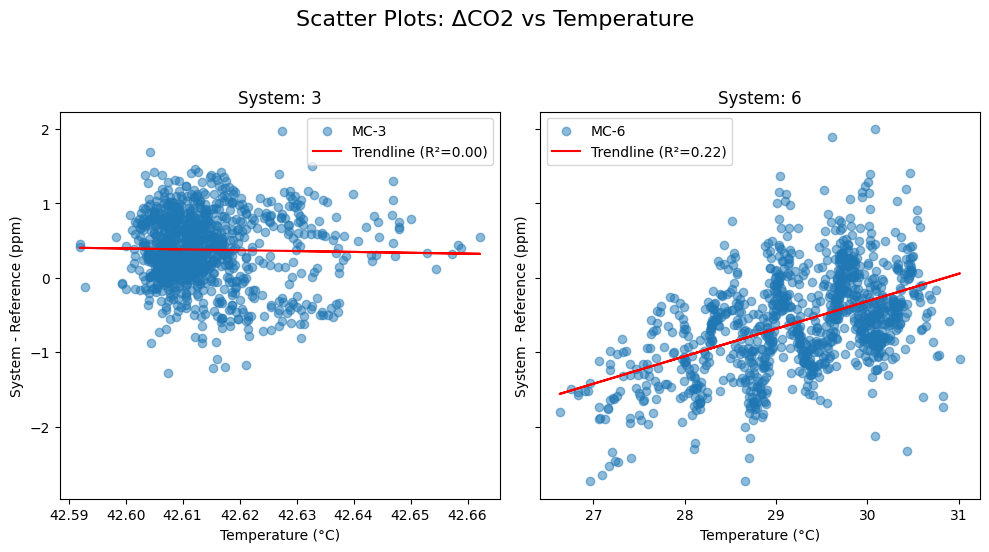

In [118]:
max_col, max_row = 2, 2

plot_scatter_with_trendline(df_s, "gmp343_temperature", "diff", max_col, max_row, "Temperature (°C)", "System - Reference (ppm)","Scatter Plots: ΔCO2 vs Temperature")

 Fragen

- **Vergleich der Systeme:**  
  Vergleicht anhand von Scatter Plots, wie sich die Temperaturregelung der beiden Systeme (System 6 (v1) versus System 3 (v2)) auf die Messgenauigkeit auswirkt.  

- **Auswirkungen der Temperaturvariabilität:**  
  Diskutiert, inwiefern die präzise Temperaturstabilisierung in System 3 (v2) zu geringeren Schwankungen und damit zu einer besseren Messperformance führt, und wie sich dies im Vergleich zu den Ergebnissen von System 6 zeigt.

- **Weitere Lösungen zur Systemstabilisierung:**  
  Diskutiert, welche weiteren Lösungen euch zur Stabilisierung der Sensorsensibilität einfallen. Wie gut lässt sich eure Lösung in die Praxis umsetzen?